# Lab 0 — Seeing a qubit in Qiskit  
### Statevectors, Bloch sphere, interference, and measurement

This lab follows the single-qubit lecture. You will:

- build one-qubit circuits,
- read amplitudes from the statevector,
- visualize states on the Bloch sphere,
- verify the Born rule by sampling,
- see that **global phase** is unobservable, while **relative phase** controls interference.

## 0. Setup

If you are running this locally and Qiskit is not installed, uncomment the install cell below.

In [ ]:

# If needed, install dependencies (uncomment):
# %pip install qiskit qiskit-aer matplotlib

In [1]:

import numpy as np

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator

from qiskit.quantum_info import Statevector, Pauli
from qiskit.visualization import plot_bloch_multivector, plot_histogram

import qiskit
print("qiskit version:", qiskit.__version__)

qiskit version: 2.3.0


## 1. Statevectors are amplitudes

In the computational basis,
$$
|0\rangle=\begin{pmatrix}1\\0\end{pmatrix},\qquad
|1\rangle=\begin{pmatrix}0\\1\end{pmatrix}.
$$

In [2]:

psi0 = Statevector.from_label("0")
psi1 = Statevector.from_label("1")

print("|0> =", psi0.data)
print("|1> =", psi1.data)

|0> = [1.+0.j 0.+0.j]
|1> = [0.+0.j 1.+0.j]


### 1.1 Build $|+\rangle$ and $|-\rangle$

$$
|+\rangle=\frac{|0\rangle+|1\rangle}{\sqrt{2}},\qquad
|-\rangle=\frac{|0\rangle-|1\rangle}{\sqrt{2}}.
$$

In [3]:

qc_plus = QuantumCircuit(1)
qc_plus.h(0)
psi_plus = Statevector(qc_plus)
print("|+> =", psi_plus.data)

qc_minus = QuantumCircuit(1)
qc_minus.h(0)
qc_minus.z(0)
psi_minus = Statevector(qc_minus)
print("|-> =", psi_minus.data)

|+> = [0.70710678+0.j 0.70710678+0.j]
|-> = [ 0.70710678+0.j -0.70710678+0.j]


## 2. Bloch sphere visualization

Plot a few states.

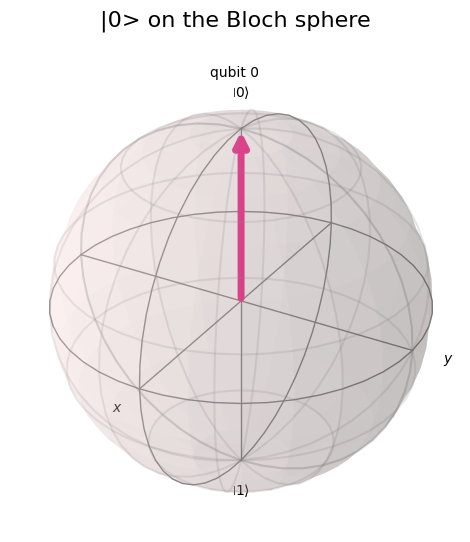

In [4]:
plot_bloch_multivector(psi0, title="|0> on the Bloch sphere")

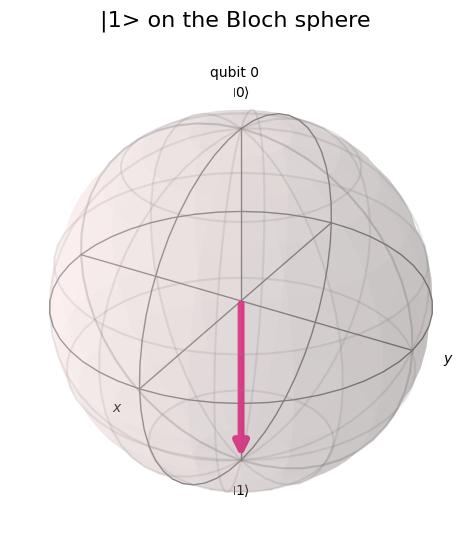

In [5]:
plot_bloch_multivector(psi1, title="|1> on the Bloch sphere")

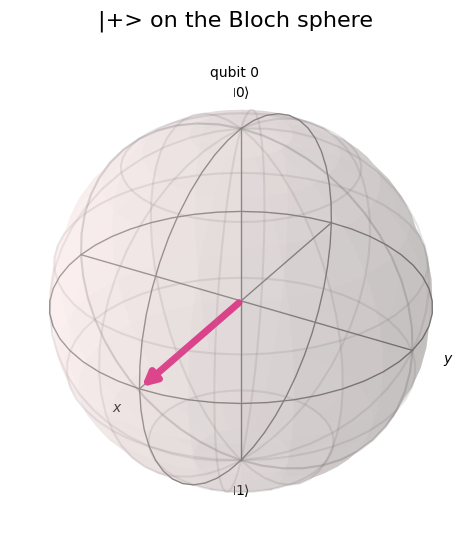

In [6]:
plot_bloch_multivector(psi_plus, title="|+> on the Bloch sphere")

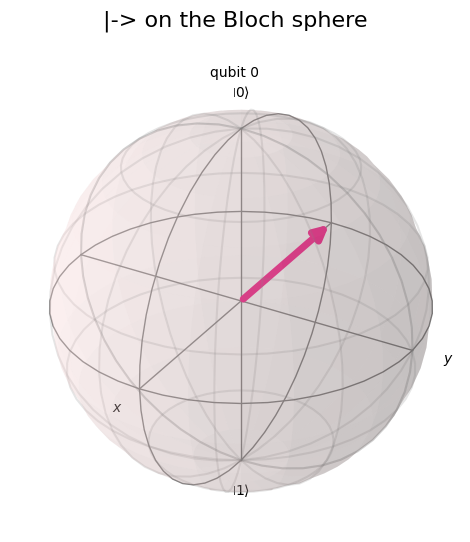

In [7]:
plot_bloch_multivector(psi_minus, title="|-> on the Bloch sphere")

### 2.1 Bloch coordinates via expectation values

$$
x=\langle X\rangle,\quad y=\langle Y\rangle,\quad z=\langle Z\rangle.
$$

In [8]:

def bloch_coords(state: Statevector):
    x = np.real(state.expectation_value(Pauli("X")))
    y = np.real(state.expectation_value(Pauli("Y")))
    z = np.real(state.expectation_value(Pauli("Z")))
    return np.array([x, y, z])

for name, st in [("|0>", psi0), ("|1>", psi1), ("|+>", psi_plus), ("|->", psi_minus)]:
    print(name, bloch_coords(st))

|0> [0. 0. 1.]
|1> [ 0.  0. -1.]
|+> [1. 0. 0.]
|-> [-1.  0.  0.]


## 3. Global phase is invisible

$$
|\psi\rangle \rightarrow e^{i\gamma}|\psi\rangle
$$
does not change measurement probabilities.

In [9]:

gamma = 0.37
psi = psi_plus
psi_phase = Statevector(np.exp(1j * gamma) * psi.data)

print("original probabilities:", psi.probabilities_dict())
print("with global phase:", psi_phase.probabilities_dict())

original probabilities: {np.str_('0'): np.float64(0.4999999999999999), np.str_('1'): np.float64(0.4999999999999999)}
with global phase: {np.str_('0'): np.float64(0.4999999999999999), np.str_('1'): np.float64(0.4999999999999999)}


## 4. Measurement and the Born rule (sampling)

Born rule in the $Z$ basis:
$$
|\psi\rangle=\alpha|0\rangle+\beta|1\rangle
\Rightarrow
P(0)=|\alpha|^2,\; P(1)=|\beta|^2.
$$

In [10]:
sim = AerSimulator()

### 4.1 Measure $|+\rangle$ in the $Z$ basis

Theory says $P(0)=P(1)=1/2$.

In [11]:

qc = QuantumCircuit(1, 1)
qc.h(0)
qc.measure(0, 0)

result = sim.run(transpile(qc, sim), shots=2000).result()
counts = result.get_counts()
counts

{'1': 981, '0': 1019}

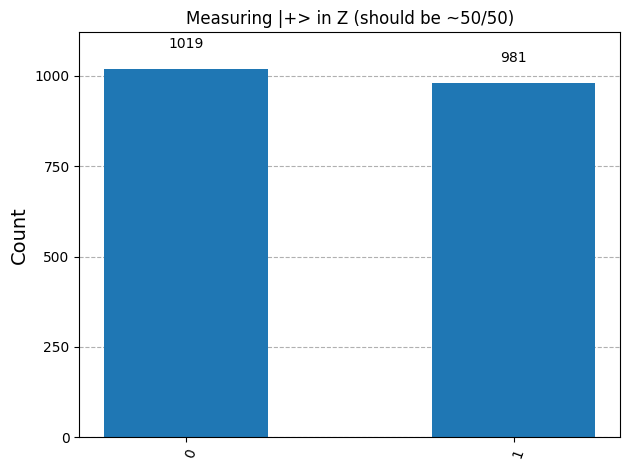

In [12]:
plot_histogram(counts, title="Measuring |+> in Z (should be ~50/50)")

## 5. Measuring in other bases = rotate then measure $Z$

- Measure in $X$: apply $H$, then measure $Z$.
- Measure in $Y$: apply $S^\dagger H$, then measure $Z$.

### 5.1 Measure $|0\rangle$ in the $X$ basis (should be ~50/50)

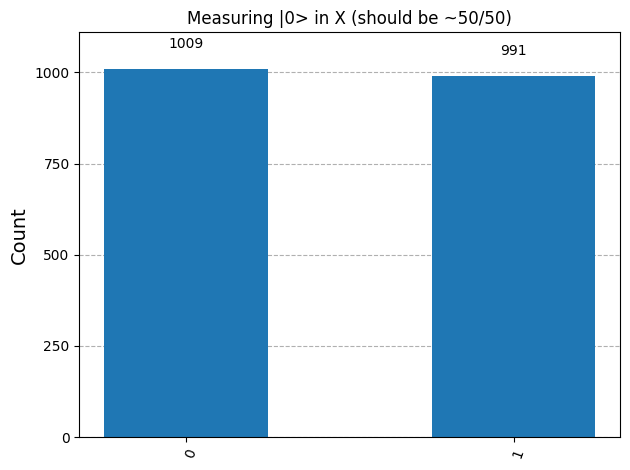

In [13]:

qc = QuantumCircuit(1, 1)
qc.h(0)
qc.measure(0, 0)

result = sim.run(transpile(qc, sim), shots=2000).result()
counts = result.get_counts()
plot_histogram(counts, title="Measuring |0> in X (should be ~50/50)")

### 5.2 Measure $|0\rangle$ in the $Y$ basis (should be ~50/50)

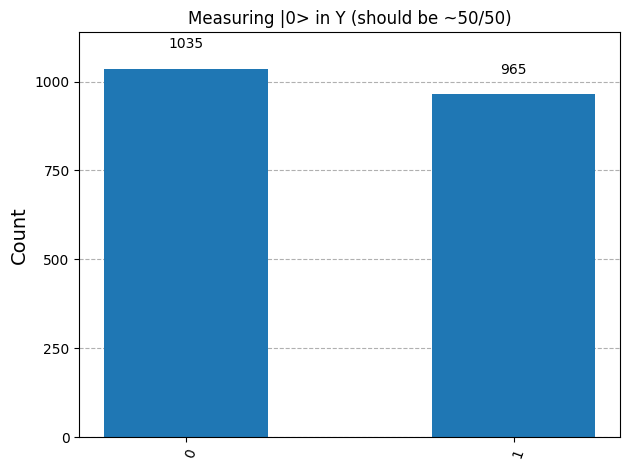

In [14]:

qc = QuantumCircuit(1, 1)
qc.sdg(0)
qc.h(0)
qc.measure(0, 0)

result = sim.run(transpile(qc, sim), shots=2000).result()
counts = result.get_counts()
plot_histogram(counts, title="Measuring |0> in Y (should be ~50/50)")

## 6. One-qubit interferometer: $H \rightarrow R_z(\phi) \rightarrow H$

Circuit:
$$
|0\rangle \xrightarrow{H} \xrightarrow{R_z(\phi)} \xrightarrow{H} \text{ measure in } Z.
$$

Theory:
$$
P(1)=\sin^2(\phi/2).
$$

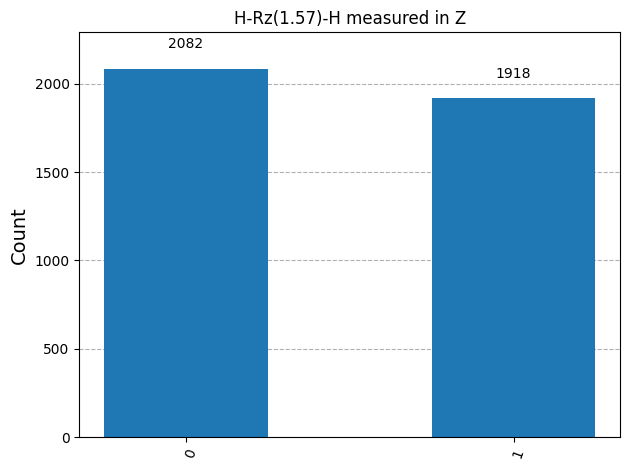

In [15]:

phi = np.pi/2

qc = QuantumCircuit(1, 1)
qc.h(0)
qc.rz(phi, 0)
qc.h(0)
qc.measure(0, 0)

result = sim.run(transpile(qc, sim), shots=4000).result()
counts = result.get_counts()
plot_histogram(counts, title=f"H-Rz({phi:.2f})-H measured in Z")

### 6.1 Sweep $\phi$ and compare to $\sin^2(\phi/2)$

In [17]:

import matplotlib.pyplot as plt

phis = np.linspace(0, 2*np.pi, 41)
p1_empirical = []
p1_theory = []

shots = 3000

for phi in phis:
    qc = QuantumCircuit(1, 1)
    qc.h(0)
    qc.rz(phi, 0)
    qc.h(0)
    qc.measure(0, 0)

    result = sim.run(transpile(qc, sim), shots=shots).result()
    counts = result.get_counts()
    p1_empirical.append(counts.get("1", 0) / shots)
    p1_theory.append(np.sin(phi/2)**2)

plt.figure()
plt.plot(phis, p1_empirical, marker="o", linestyle="none", label="empirical")
plt.plot(phis, p1_theory, label="theory")
plt.xlabel(r"$\\phi$")
plt.ylabel(r"$P(1)$")
plt.legend()
plt.title(r"Interference: $P(1)=\\sin^2(\\phi/2)$")
plt.show()

ValueError: 
Interference: $P(1)=\\sin^2(\\phi/2)$
              ^
ParseException: Expected end of text, found '$'  (at char 14), (line:1, col:15)

<Figure size 640x480 with 1 Axes>

## Turn-in (suggested)

1. Show Bloch spheres for $|0\rangle,|1\rangle,|+\rangle,|-\rangle$.
2. Verify global phase invariance for one state and one $\gamma$.
3. For the interferometer circuit $H R_z(\phi) H$, pick two different $\phi$ values and:
   - predict $P(1)=\sin^2(\phi/2)$,
   - run the simulator and compare.
4. Conceptual (3–5 sentences): why doesn’t $R_z(\phi)$ change $Z$-basis probabilities by itself, but *does* after the final $H$?